In [74]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image

In [75]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('test_data/*.jpg')

Start finding chessboard corners...
find the chessboard corners of test_data/IMAG2040.jpg


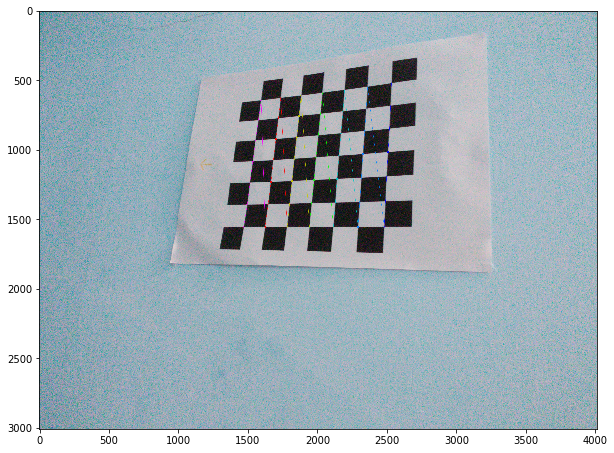

find the chessboard corners of test_data/IMAG2047.jpg


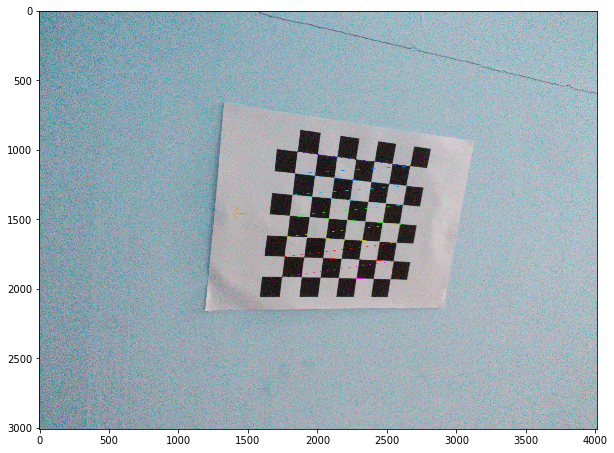

find the chessboard corners of test_data/IMAG2045.jpg


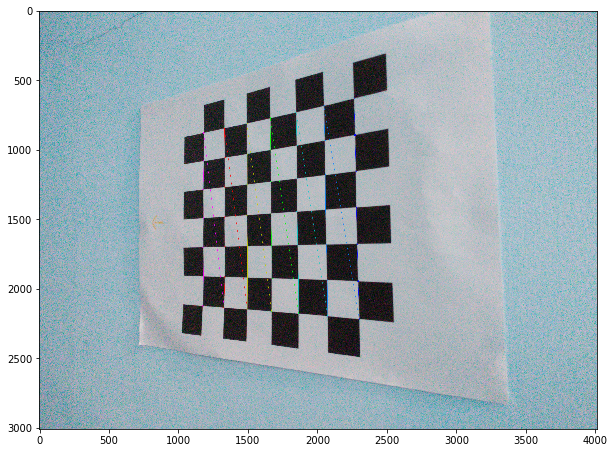

find the chessboard corners of test_data/IMAG2041.jpg


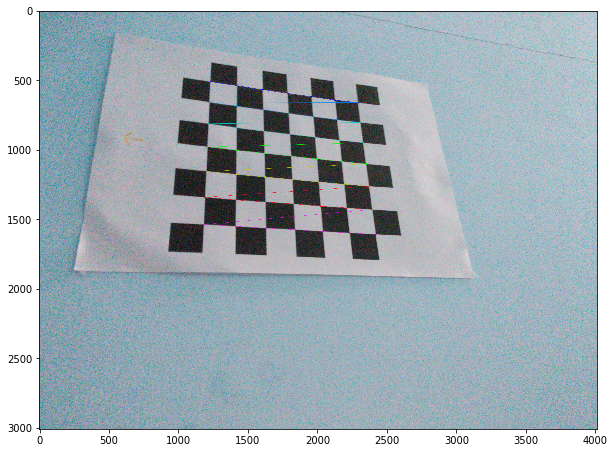

find the chessboard corners of test_data/IMAG2046.jpg


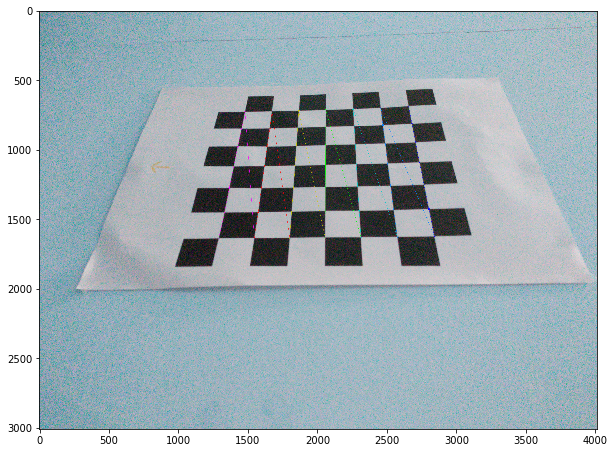

find the chessboard corners of test_data/IMAG2048.jpg


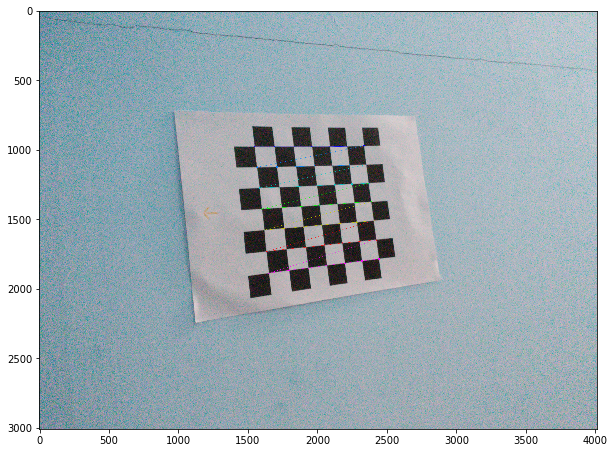

find the chessboard corners of test_data/IMAG2044.jpg


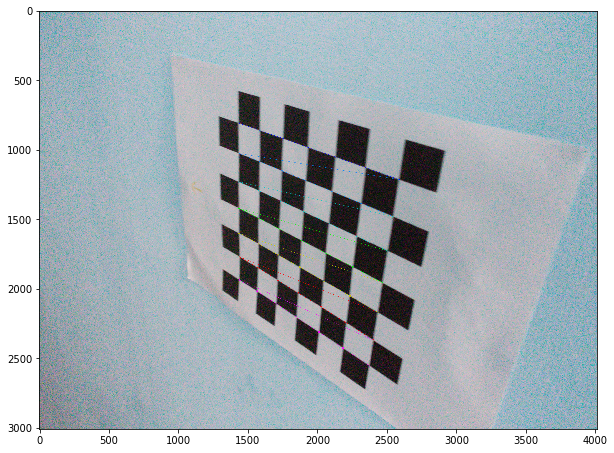

find the chessboard corners of test_data/IMAG2039.jpg


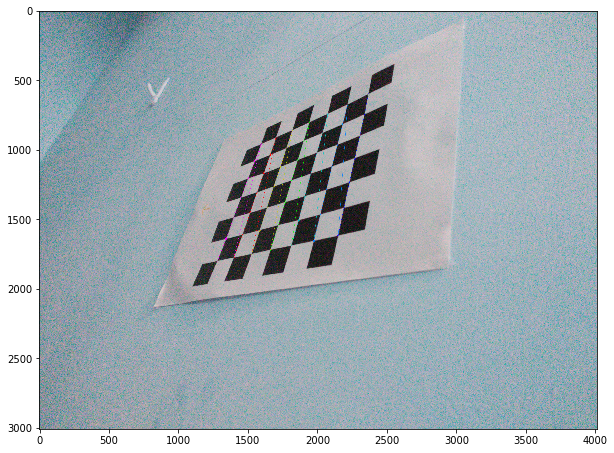

find the chessboard corners of test_data/IMAG2042.jpg


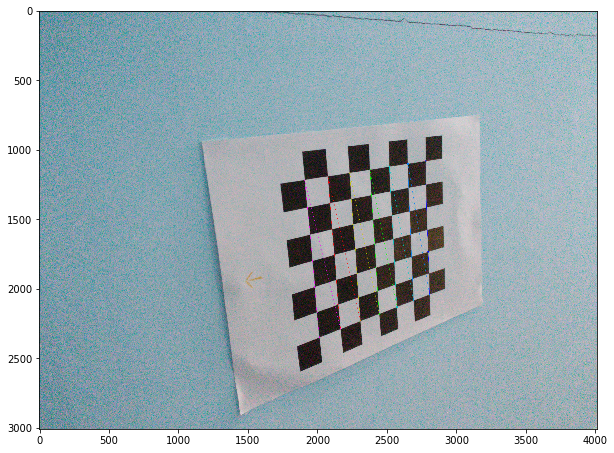

find the chessboard corners of test_data/IMAG2043.jpg


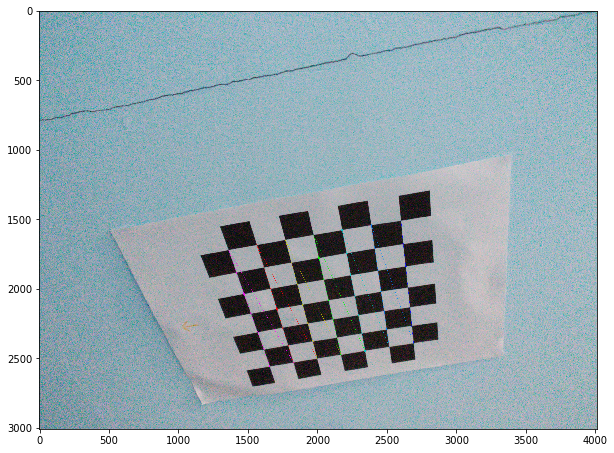

In [76]:
# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x, corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.show()

In [77]:
origin_pos = ['rt', 'lt', 'rt', 'lt', 'rt', 'lt', 'lt', 'rt', 'rt', 'rt']
for p in origin_pos:
    objp = np.zeros((corner_x*corner_y,3), np.float32)
    if p == 'rt':
        objp[:,:2] = np.mgrid[corner_x-1:-1:-1, corner_y-1:-1:-1].T.reshape(-1,2)
    elif p == 'lt':
        objp[:,:2] = np.mgrid[corner_x-1:-1:-1, corner_y-1:-1:-1][::-1].T.reshape(-1,2)
    objpoints.append(objp)

In [80]:
# Calculate Homography matrix
H = np.empty((len(images), 3, 3), dtype=float)
for i, (imgpts, objpts) in enumerate(zip(imgpoints, objpoints)):
    M = np.empty((corner_x*corner_y*2, 9), dtype=float)
    for j, (imgp, objp) in enumerate(zip(imgpts, objpts)):
        x, y = imgp[0]
        X, Y, _ = objp
        M[j*2, :] = [-X, -Y, -1, 0, 0, 0, x*X, x*Y, x]
        M[j*2+1, :] = [0, 0, 0, -X, -Y, -1, y*X, y*Y, y]
    u, s, v = np.linalg.svd(M)
    H[i] = v[np.argmin(s)].reshape(3, 3)
    H[i] /= H[i, -1, -1]

# Calcualte B = K^(-T) * K^(-1)
V = np.empty((len(images)*2, 6), dtype=float)
for i, Hi in enumerate(H):
    V[i*2, :] = [
        Hi[0, 0]*Hi[0, 1], 
        Hi[0, 0]*Hi[1, 1] + Hi[1, 0]*Hi[0, 1], 
        Hi[0, 0]*Hi[2, 1] + Hi[2, 0]*Hi[0, 1],
        Hi[1, 0]*Hi[1, 1], 
        Hi[1, 0]*Hi[2, 1] + Hi[2, 0]*Hi[1, 1], 
        Hi[2, 0]*Hi[2, 1]
    ]
    V[i*2+1, :] = [
        Hi[0, 0]**2 - Hi[0, 1]**2,
        2*(Hi[0, 0]*Hi[1, 0] - Hi[0, 1]*Hi[1, 1]),
        2*(Hi[0, 0]*Hi[2, 0] - Hi[0, 1]*Hi[2, 1]),
        Hi[1, 0]**2 - Hi[1, 1]**2,
        2*(Hi[1, 0]*Hi[2, 0] - Hi[1, 1]*Hi[2, 1]),
        Hi[2, 0]**2 - Hi[2, 1]**2
    ]
u, s, v = np.linalg.svd(V)
b = v[np.argmin(s)]
B = np.array([
    [b[0], b[1], b[2]],
    [b[1], b[3], b[4]],
    [b[2], b[4], b[5]]
])

# Compute K using Cholesky decomposition
try:
    K = np.linalg.inv(np.linalg.cholesky(B).T)
    K /= K[-1, -1]
    
# Handle if B is not positive definite
except np.linalg.LinAlgError:
    v0 = (B[0, 1]*B[0, 2])/(B[0, 0]*B[1, 1] - B[0, 1]**2)
    l = B[2, 2] - (B[0, 2]**2 + v0*(B[0, 1]*B[0, 2] - B[0, 0]*B[1, 2]))/B[0, 0]
    alpha = (l/B[0 ,0])**0.5
    beta = ((l*B[0, 0])/(B[0, 0]*B[1, 1] - B[0, 1]**2))**0.5
    gamma = (-B[0, 1]*(alpha**2)*beta)/l
    u0 = (gamma*v0)/beta - (B[0, 2]*(alpha**2))/l
    
    v01 = (B[0][1]*B[0][2]-B[0][0]*B[1][2])/(B[0][0]*B[1][1]-B[0][1]**2)
    ld = B[2][2]-(B[0][2]**2+v0*(B[0][1]*B[0][2]-B[0][0]*B[1][2]))/B[0][0]
    al = (ld/B[0][0])**0.5
    bt = (ld*B[0][0]/(B[0][0]*B[1][1]-B[0][1]**2))**0.5
    gm = -1*B[0][1]*al*al*bt/ld
    u01 = gm*v0/bt - B[0][2]*al*al/ld
    
    print(v0, v01)
    print(l, ld)
    print(alpha, al)
    print(beta, bt)
    print(gamma, gm)
    print(u0, u01)

    K = np.zeros((3, 3))
    K[0, 0], K[0, 1], K[0, 2], K[1, 1], K[1, 2], K[2, 2]= alpha, gamma, u0, beta, v0, 1 
K_inv = np.linalg.inv(K)

# Calculate extrinsics matrices
R = np.empty((len(images), 3, 3), dtype=float)
T = np.empty((len(images), 3, 1), dtype=float)
extrinsics = np.empty((len(images), 6), dtype=float)
for i, Hi in enumerate(H):
    l = 1/np.linalg.norm(np.dot(K_inv, Hi[:, 0]))
    R[i, :, 0] = l*np.dot(K_inv, Hi[:, 0])
    R[i, :, 1] = l*np.dot(K_inv, Hi[:, 1])
    R[i, :, 2] = np.cross(R[i, :, 0], R[i, :, 1])
    T[i, :] = l*np.dot(K_inv, Hi[:, 2].reshape(3, 1))
    rvec, _ = cv2.Rodrigues(R[i])
    extrinsics[i] = [rvec[0], rvec[1], rvec[2], T[i, 0], T[i, 1], T[i, 2]]

16.296201184853448 1471.9758486317537
-0.7634952300949902 -0.7634952300949902
3550.921771364998 3550.921771364998
3543.5068317609107 3543.5068317609107
29.432067018099623 29.432067018099623
1970.3545631471177 1970.3545631471177


Show the camera extrinsics


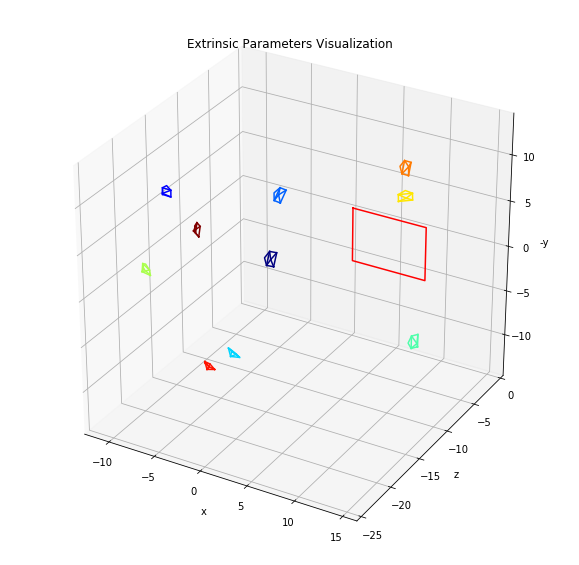

'\nfor angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.show()\n    plt.pause(.001)\n'

In [79]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = K
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()

#animation for rotating plot
'''
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.show()
    plt.pause(.001)
'''

In [72]:
print('Camera calibration...')
img_size = (img.shape[1], img.shape[0])
# You need to comment these functions and write your calibration function from scratch.
# Notice that rvecs is rotation vector, not the rotation matrix, and tvecs is translation vector.
# In practice, you'll derive extrinsics matrixes directly. The shape must be [pts_num,3,4], and use them to plot.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
Vr = np.array(rvecs)
Tr = np.array(tvecs)
extrinsics = np.concatenate((Vr, Tr), axis=1).reshape(-1,6)

Camera calibration...


Show the camera extrinsics


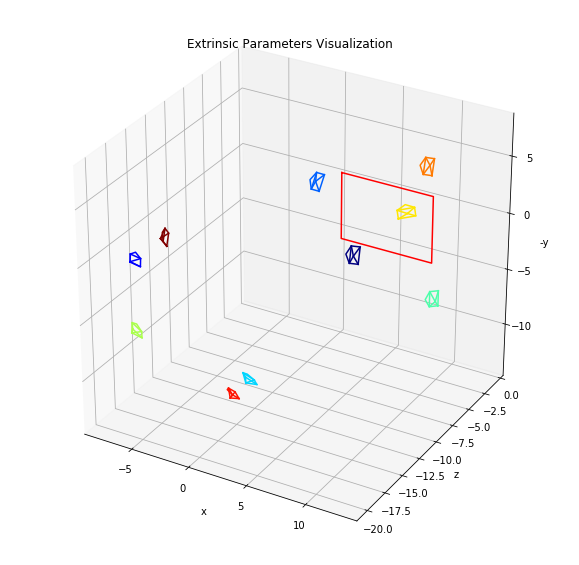

'\nfor angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.show()\n    plt.pause(.001)\n'

In [73]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = K
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()

#animation for rotating plot
'''
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.show()
    plt.pause(.001)
'''